# Imports

In [874]:
import json
import requests
import numpy as np
import pandas as pd
from http import HTTPStatus
from matplotlib import pyplot as plt
from typing import Iterable, Dict, Union, List

# Activity 1

## 1.1 Sub-activity: Open Data COVID-19 API

### Task 1

In [875]:
# The code for Task 1 is retrieved from https://coronavirus.data.gov.uk/details/developers-guide/main-api

StructureType = Dict[str, Union[dict, str]]
FiltersType = Iterable[str]
APIResponseType = Union[List[StructureType], str]

def get_API_data(filters:FiltersType , structure: StructureType) -> APIResponseType:
    # API URL
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"

    api_params = {
        "filters": "areaType=" + filters["areaType"],
        "structure": json.dumps(structure)
    }

    data = []
    page_number = 1
    
    while True:
        # Adding page number to query params
        api_params["page"] = page_number

        response = requests.get(endpoint, params=api_params)

        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f"Request failed: {response.text}")
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break

        current_data = response.json()
        
        # If there is no data in vaccination_age, set the value to NaN for Pandas" DataFrame
        for age in current_data["data"]:
            if not age["vaccination_age"]:
                age["vaccination_age"] = np.nan

        page_data: List[StructureType] = current_data["data"]
       
        data.extend(page_data)

        # The "next" attribute in "pagination" will be `None`
        # when we reach the end.
        if current_data["pagination"]["next"] is None:
            break

        page_number += 1

    return data

### Task 2

In [876]:
nation_filters = {"areaType":"nation"}
region_filters = {"areaType":"region"}

structure = {
    "date": "date",
    "name": "areaName",
    "daily_cases": "newCasesBySpecimenDate",
    "cumulative_cases": "cumCasesBySpecimenDate",
    "daily_deaths": "newDeaths28DaysByPublishDate",
    "cumulative_deaths": "cumDeaths28DaysByPublishDate",
    "cumulative_vaccinated": "cumPeopleVaccinatedCompleteByVaccinationDate",
    "vaccination_age": "vaccinationsAgeDemographics"
    }

results_json_national = get_API_data(nation_filters, structure)
results_json_regional = get_API_data(region_filters, structure)

## 1.2 Sub-activity: Shaping the COVID data into different dataframes

### Task 3

In [877]:
covid_data_list = results_json_national + results_json_regional

### Task 4

In [878]:
covid_data = pd.DataFrame(covid_data_list)

### Task 5

In [879]:
covid_data.drop(covid_data[covid_data["name"] == "England"].index, inplace=True)

### Task 6

In [880]:
covid_data.rename(columns={"name": "area"}, inplace=True)

### Task 7

In [881]:
covid_data["date"] = pd.to_datetime(covid_data["date"])

### Task 8

In [882]:
# Since the vaccination_age will return a emtpy list if the data is not available
# I set the empty list value to NaN for Pandas" DataFrame by using Numpy"s function "np.nan"
# Therefore, all the Nan values will be counted as missing data in the dataframe
nan = covid_data.isna().sum().sum()
print("The amount of missing data is {}.".format(nan)) 

The amount of missing data is 13867.


### Task 9

In [883]:
covid_data["cumulative_cases"] = covid_data.groupby("area")["cumulative_cases"].fillna(method="bfill")
covid_data["cumulative_deaths"] = covid_data.groupby("area")["cumulative_deaths"].fillna(method="bfill")
covid_data["cumulative_vaccinated"] = covid_data.groupby("area")["cumulative_vaccinated"].fillna(method="bfill")


### Task 10

In [884]:
if covid_data["cumulative_deaths"].isnull().sum() != 0:
    covid_data.drop(covid_data[covid_data["cumulative_deaths"].isnull() == True].index, inplace=True)
if covid_data["cumulative_cases"].isnull().sum() != 0:
    covid_data.drop(covid_data[covid_data["cumulative_cases"].isnull() == True].index, inplace=True)
if covid_data["cumulative_vaccinated"].isnull().sum() != 0:
    covid_data.drop(covid_data[covid_data["cumulative_vaccinated"].isnull() == True].index, inplace=True)

### Task 11

In [885]:
daily_cases_roll_avg = covid_data["daily_cases"].rolling(7).mean().shift(-6).rename("daily_cases_roll_avg")
daily_deaths_roll_avg = covid_data["daily_deaths"].rolling(7).mean().shift(-6).rename("daily_deaths_roll_avg")
covid_data = pd.concat([covid_data, daily_cases_roll_avg, daily_deaths_roll_avg],axis=1)

### Task 12

In [886]:
covid_data.drop(columns=["daily_cases", "daily_deaths"],inplace=True)

### Task 13

In [887]:
covid_data_vaccinations = covid_data.loc[:,["date","area","vaccination_age"]]

### Task 14

In [888]:
exploded = pd.DataFrame(covid_data_vaccinations.explode("vaccination_age", ignore_index=True))
normalized = pd.json_normalize(exploded["vaccination_age"])
covid_data_vaccinations_wide = pd.concat([exploded, normalized], axis=1)
covid_data_vaccinations_wide.drop(columns=[
    "vaccination_age",
    "cumPeopleVaccinatedThirdInjectionByVaccinationDate",
    "newPeopleVaccinatedThirdInjectionByVaccinationDate",
    "cumVaccinationThirdInjectionUptakeByVaccinationDatePercentage",
    "cumPeopleVaccinatedAutumn22ByVaccinationDate",
    "cumPeopleVaccinatedSpring22ByVaccinationDate",
    "newPeopleVaccinatedAutumn22ByVaccinationDate",
    "newPeopleVaccinatedSpring22ByVaccinationDate",
    "cumVaccinationAutumn22UptakeByVaccinationDatePercentage",
    "cumVaccinationSpring22UptakeByVaccinationDatePercentage"
    ], inplace=True)

## 1.3 Sub-activity: Aggregating, plotting, and analysing

### Task 15

<AxesSubplot:title={'center':'Cumulative Cases in London through time'}, xlabel='date'>

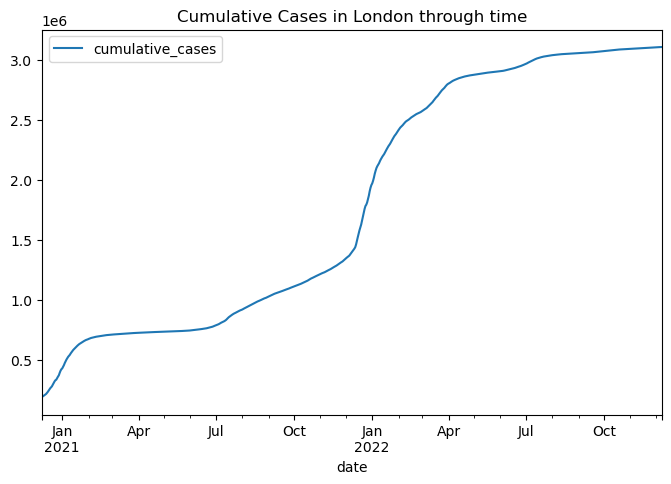

In [912]:
cumulative_cases_in_London_through_time = covid_data.loc[covid_data["area"] == "London", ["date", "cumulative_cases"]]
cumulative_cases_in_London_through_time.plot(x = "date", y = "cumulative_cases", figsize = (8,5), title = "Cumulative Cases in London through time")

### Task 16

<AxesSubplot:xlabel='date'>

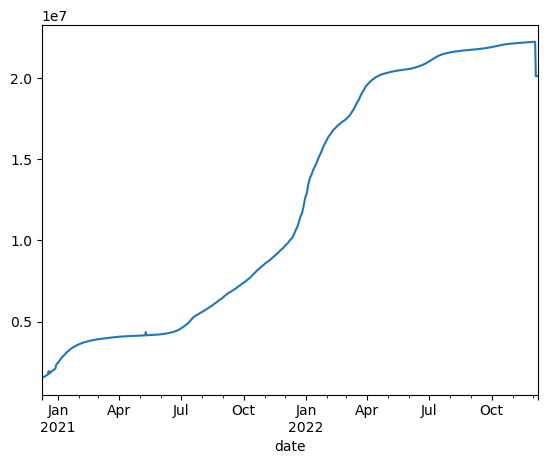

In [890]:
cumulative_cases_summed_over_all_areas = covid_data.groupby("date")["cumulative_cases"].sum()
cumulative_cases_summed_over_all_areas.plot()

### Task 17

<AxesSubplot:xlabel='date'>

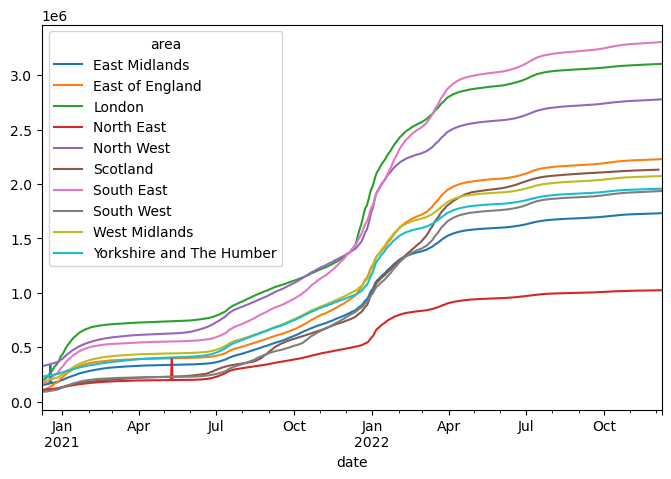

In [913]:
cumulative_cases_of_different_areas = covid_data.groupby(["date","area"])["cumulative_cases"].sum().unstack()
cumulative_cases_of_different_areas.plot(figsize=(8, 5))

### Task 18

### Task 19

<AxesSubplot:xlabel='date'>

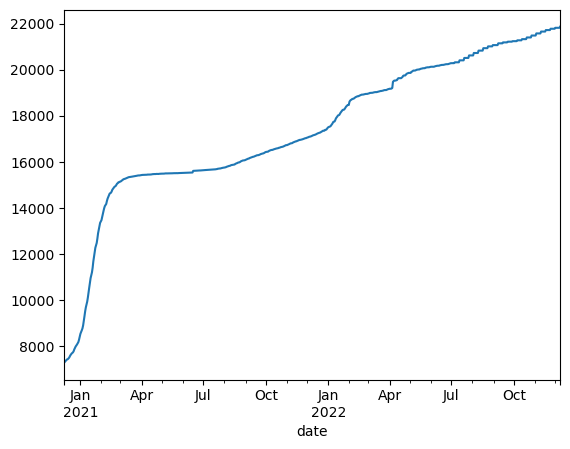

In [892]:
evolution_of_cumulative_deaths_in_London = covid_data[covid_data["area"] == "London"].groupby("date")["cumulative_deaths"].sum()
evolution_of_cumulative_deaths_in_London.plot()

### Task 20

### Task 21

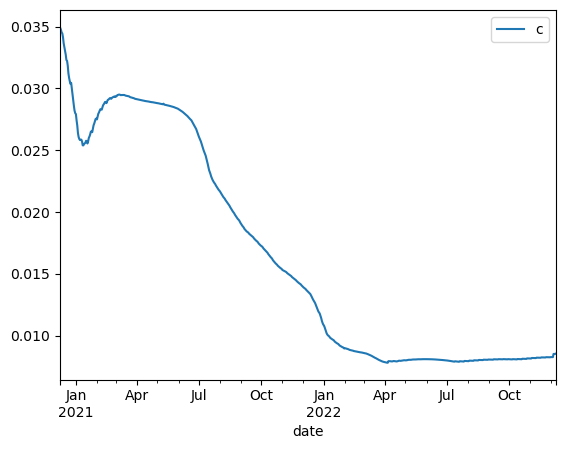

In [893]:
cumulative_deaths_per_cases = covid_data.groupby(["date"])["cumulative_deaths"].sum() / covid_data.groupby("date")["cumulative_cases"].sum()

cumulative_deaths_per_cases.plot()
plt.legend("cumulative_deaths_per_cases")

### Task 22

### Task 23

<AxesSubplot:xlabel='date'>

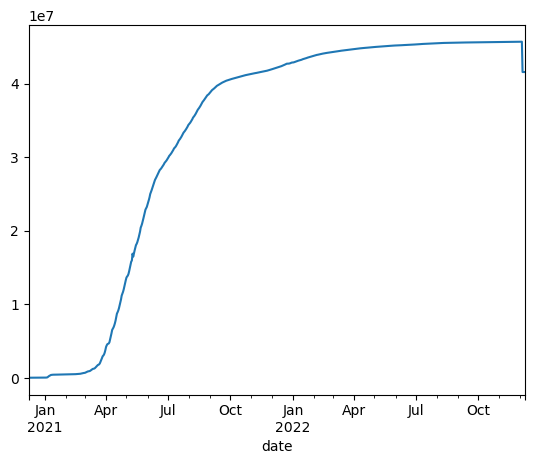

In [894]:
sum_of_cumulative_vaccinations_over_all_areas = covid_data.groupby("date")["cumulative_vaccinated"].sum()
sum_of_cumulative_vaccinations_over_all_areas.plot()

### Task 24

<AxesSubplot:xlabel='date'>

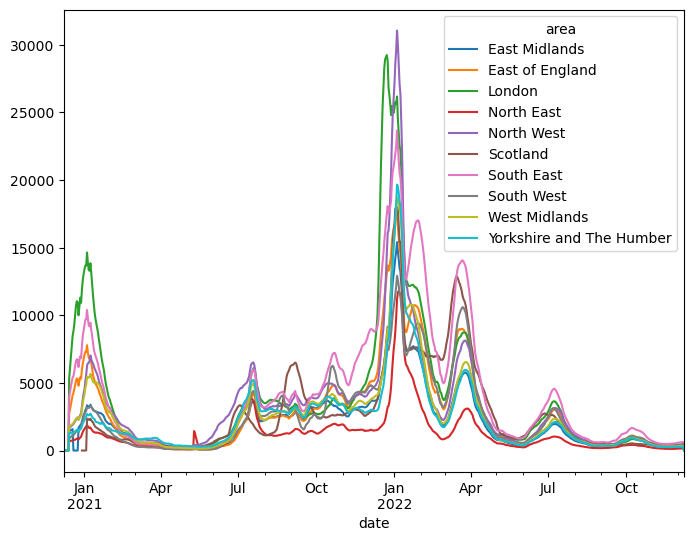

In [895]:
daily_cases_rolling_average_separated_by_areas = covid_data.groupby(["date","area"])["daily_cases_roll_avg"].sum().unstack()
daily_cases_rolling_average_separated_by_areas.plot(figsize=(8, 6))

### Task 25

### Task 26

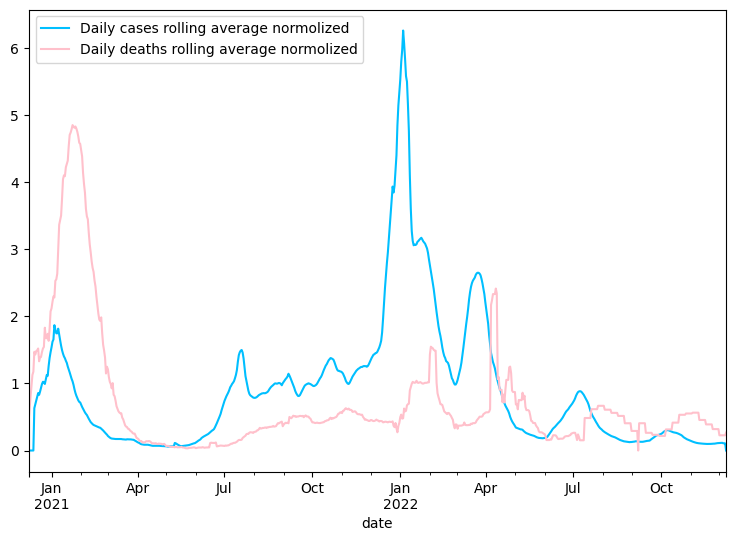

In [896]:
covid_data["daily_cases_roll_avg_norm"] = covid_data["daily_cases_roll_avg"] / covid_data["daily_cases_roll_avg"].max()
covid_data["daily_deaths_roll_avg_norm"] = covid_data["daily_deaths_roll_avg"] / covid_data["daily_deaths_roll_avg"].max()
covid_data.groupby("date")["daily_cases_roll_avg_norm"].sum().plot(figsize=(9, 6), color = "deepskyblue")
covid_data.groupby("date")["daily_deaths_roll_avg_norm"].sum().plot(figsize=(9, 6), color = "pink")
plt.legend(["Daily cases rolling average normolized", "Daily deaths rolling average normolized"])

### Task 27

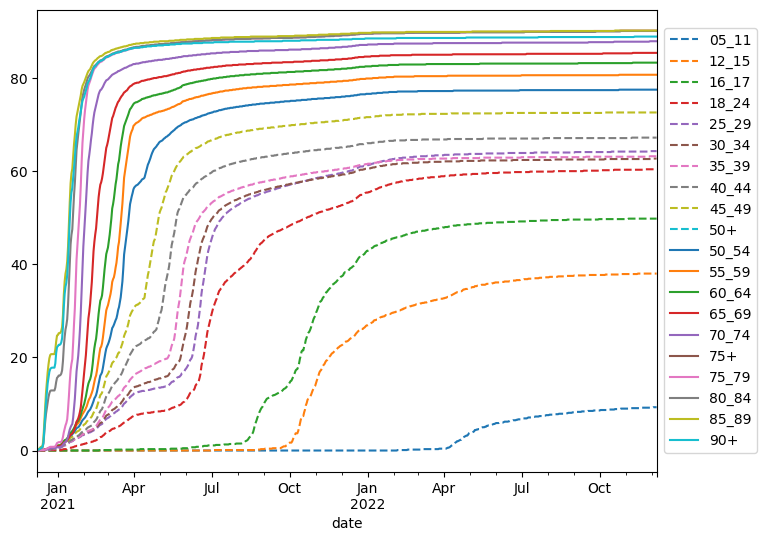

In [897]:
covid_data_vaccinations_wide_london = covid_data_vaccinations_wide[covid_data_vaccinations_wide["area"] == "London"]
covid_data_vaccinations_wide_scotland = covid_data_vaccinations_wide[covid_data_vaccinations_wide["area"] == "Scotland"]

covid_data_vaccinations_wide_london = covid_data_vaccinations_wide_london[["date", "age", "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage"]]
columns = covid_data_vaccinations_wide_london.groupby('date')['age'].apply(list)[0]
covid_data_vaccinations_wide_london = covid_data_vaccinations_wide_london.groupby('date')['cumVaccinationFirstDoseUptakeByVaccinationDatePercentage'].apply(list).apply(pd.Series)
covid_data_vaccinations_wide_london.columns=columns
covid_data_vaccinations_wide_london.reset_index(inplace=True)

covid_data_vaccinations_wide_london.plot(figsize=(8, 6), x="date", y=columns, style=["--" for _ in range(10)])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Task 28

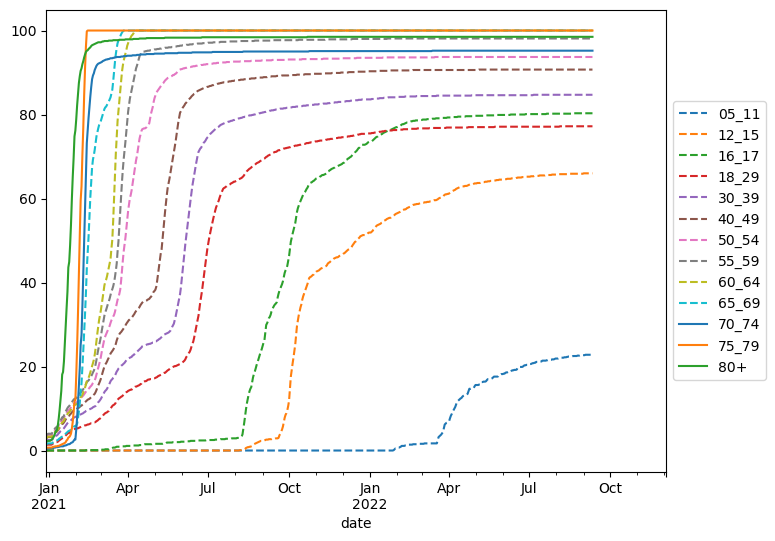

In [898]:
covid_data_vaccinations_wide_scotland = covid_data_vaccinations_wide_scotland[["date", "age", "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage"]]
columns = covid_data_vaccinations_wide_scotland.groupby('date')['age'].apply(list)[0]
covid_data_vaccinations_wide_scotland = covid_data_vaccinations_wide_scotland.groupby('date')['cumVaccinationFirstDoseUptakeByVaccinationDatePercentage'].apply(list).apply(pd.Series)
covid_data_vaccinations_wide_scotland.columns=columns
covid_data_vaccinations_wide_scotland.reset_index(inplace=True)

covid_data_vaccinations_wide_scotland.plot(figsize=(8, 6), x="date", y=columns, style=["--" for _ in range(10)])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))